In [2]:
!git clone https://github.com/tareknaous/readme.git

Cloning into 'readme'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 6), reused 23 (delta 0), pack-reused 0
Receiving objects: 100% (47/47), 1.95 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
import os
os.system("""wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/UN5pmzv66OM1Pg" -O model_en""")

0

In [4]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from torch.utils.data import DataLoader, SequentialSampler

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                              do_lower_case=True)

def make_dataloader(language = 'en', n_samples_per_class = 50, batch_size = 3):

    data = pd.concat([pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_train.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_val.xlsx'), pd.read_excel(f'/content/readme/dataset/{language}/readme_{language}_test.xlsx')], axis=0)
    data.head()

    label_dict = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


    data_lang = pd.DataFrame(columns=['text', 'label'])
    data_lang['text'] = data['Sentence']
    data_lang['label'] = data['Rating'].replace(label_dict)


    samples_list = []
    for label in label_dict.values():
        samples = data_lang[data_lang['label'] == label].sample(n=n_samples_per_class, replace=False)
        samples_list.append(samples)

    data_lang = pd.concat(samples_list)

    encoded_lang = tokenizer.batch_encode_plus(
        data_lang['text'].values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_predict = encoded_lang['input_ids']
    attention_masks_predict = encoded_lang['attention_mask']
    labels_predict = torch.tensor(data_lang['label'].values)

    dataset_lang = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)


    dataloader_lang = DataLoader(dataset_lang,
                                  sampler=SequentialSampler(dataset_lang),
                                  batch_size=batch_size)
    return dataloader_lang

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [6]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
stete_dict = torch.load("./model_en")
model.load_state_dict(stete_dict)

device = "cpu"
if torch.cuda.is_available(): device = "cuda"

model = model.to(device)

In [8]:
def get_neurons_activations(dataloader):

    model.eval()

    hidens_per_layer = [[] for _ in range(13)]

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        for layer_idx, layer_hidden_states in enumerate(outputs['hidden_states']):
            hidens_per_layer[layer_idx].append(layer_hidden_states)

    hidens_stacked_per_layer = [torch.cat(layer_hidens, dim=0) for layer_hidens in hidens_per_layer]

    all_hidens_tensor = torch.stack(hidens_stacked_per_layer)

    return all_hidens_tensor

In [30]:
def pearson_corr(x, y):
    #vx = x - x.mean()
    #vy = y - y.mean()

    return (torch.dot(x, y)/(torch.norm(x)*torch.norm(y))).item()

def ANC(L1, L2):
    X = L1 - L1.mean(dim=0, keepdim=True)
    Y = L2 - L2.mean(dim=0, keepdim=True)

    anc = 0
    for i in range(X.size()[0]):
        anc+=abs(pearson_corr(X[i], Y[i]))

    return anc/X.size()[0]

def count_ANC(layers1, layers2):
    anc = []
    for i in range(13):
      anc.append(ANC(layers1[i], layers2[i]))

    return anc

In [17]:
dataloader_en = make_dataloader('en')
outs = get_neurons_activations(dataloader_en)
layers_en = outs.mean(dim=2) #.permute(0, 2, 3, 1).mean(dim=3)
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
dataloader_compare = make_dataloader('ar')
outs = get_neurons_activations(dataloader_compare)
layers_compare = outs.mean(dim=2) #.permute(0, 2, 3, 1).mean(dim=3)
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [38]:
en_ar = count_ANC(layers_en, layers_compare)

In [40]:
en_fr = [0.6852897064884503,
 0.40537027708875634,
 0.2997411974868737,
 0.254665152906673,
 0.26548712883687886,
 0.26295770685654135,
 0.25761791557597463,
 0.29912084254901855,
 0.3269791701467087,
 0.3641413440462202,
 0.41310208209751487,
 0.45792983948641147,
 0.5089772230627325]

In [41]:
en_hi = [0.6366954456553018,
 0.32401368417139265,
 0.26000099267810584,
 0.23599763790844008,
 0.23859004592096122,
 0.23732930574721348,
 0.2558840750980501,
 0.2937782060248234,
 0.30437802886862,
 0.3271417033668452,
 0.3560031609807629,
 0.40980602826961937,
 0.45910739012877455]

In [42]:
en_ru = [0.6674671115571013,
 0.3399777906488938,
 0.28103177896351555,
 0.2469819296716499,
 0.24388285253546202,
 0.22908515000347204,
 0.2059364702635988,
 0.21360122446358826,
 0.2246868432974831,
 0.25052878480327007,
 0.28324456968499967,
 0.337637209071933,
 0.39746103099314495]

In [43]:
en_ar = [0.6708066835037122,
 0.3304103905020747,
 0.2789678746165009,
 0.24668391042505391,
 0.25708808094185465,
 0.2469171056849882,
 0.260416773884402,
 0.3036157511958542,
 0.3279977541597327,
 0.35120679233960495,
 0.3892464282782748,
 0.44398097689758287,
 0.5064620257151546]

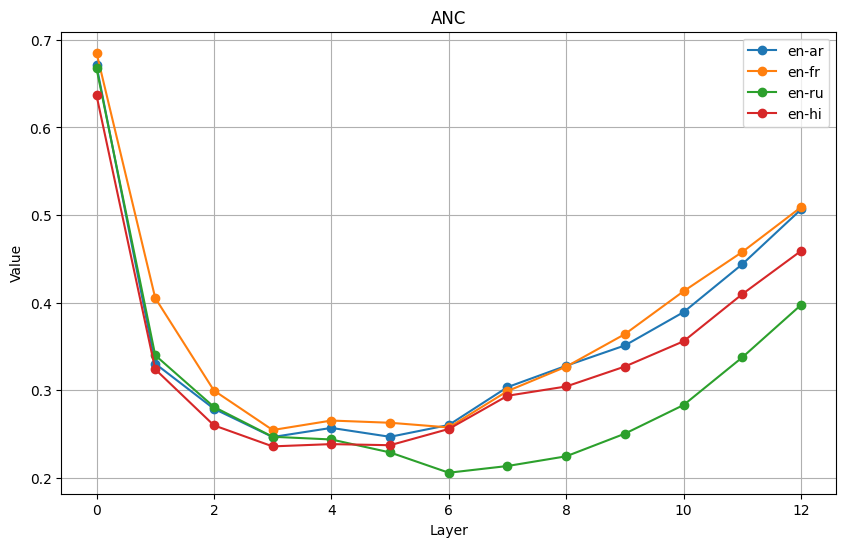

In [44]:
import matplotlib.pyplot as plt

x = np.arange(0, 13)

plt.figure(figsize=(10, 6))
plt.plot(x, en_ar, label='en-ar', marker='o')
plt.plot(x, en_fr, label='en-fr', marker='o')
plt.plot(x, en_ru, label='en-ru', marker='o')
plt.plot(x, en_hi, label='en-hi', marker='o')

plt.title('ANC')
plt.xlabel('Layer')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.show()
